In [620]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf


from IPython import display
%matplotlib inline



from sklearn.metrics import log_loss, accuracy_score, f1_score, classification_report,classification

In [4]:
data = pd.read_csv("../data/train.csv")

In [5]:
data.y.value_counts()

1.0    790
0.0    315
Name: y, dtype: int64

In [11]:
from sklearn.cross_validation import KFold, train_test_split

In [9]:
kfold = KFold(15, 3)

In [11]:
for idx in kfold:
    print(idx)

(array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), array([0, 1, 2, 3, 4]))
(array([ 0,  1,  2,  3,  4, 10, 11, 12, 13, 14]), array([5, 6, 7, 8, 9]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([10, 11, 12, 13, 14]))


In [265]:
from sklearn.ensemble import RandomForestClassifier

/home/anton/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [266]:
rf = RandomForestClassifier(100)

In [267]:
rf.fit(X_tr, y_tr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [269]:
rf_pred = rf.predict_proba(X_te)

In [271]:
log_loss(y_te, rf_pred)

0.3589249575550088

In [273]:
accuracy_score(y_te, rf_pred[:,0] < 0.5)

0.8267148014440433

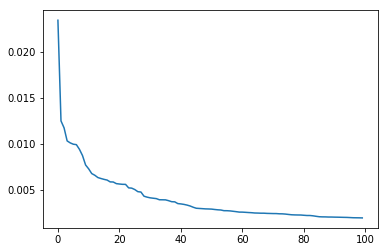

In [274]:
plt.plot(sorted(rf.feature_importances_)[::-1][:100])
plt.show()

In [278]:
rf_feauture_mask = rf.feature_importances_ > 0.005

In [8]:
X = data[data.columns[:-1]].values
y = data.y.values

In [13]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y)

In [449]:
class WeightLayer:
    def __init__(self, shape, name, w=None):
        self.shape = shape
        self.name = name
        
        with tf.variable_scope(name) as scope:
            if w is None:
                self.w = tf.get_variable('w', shape=shape, initializer=None, trainable=True)
            else:
                self.w = w
        self.scope = scope
        
    def __call__(self, inp):
        with tf.variable_scope(self.scope):
            with tf.name_scope(self.scope.original_name_scope):
                out = self.w * inp
                return out                

In [591]:
class DFS:
    def __init__(self, name, input_shape):
        self.name = name
        self.input_shape = input_shape
        
        with tf.variable_scope(name) as scope:
            self.weight_layer = WeightLayer(input_shape, 'wl')

            #with tf.variable_scope("Dense_array") as dense_scope:
            self.dense_array = [Dense(256, activation=tf.nn.relu),
                                Dense(256, activation=tf.nn.relu),
                                Dense(1, activation=tf.nn.sigmoid)]
        
        self.scope = scope
    
    def __call__(self, inp):
        with tf.variable_scope(self.scope):
            with tf.name_scope(self.scope.original_name_scope):
                weight_layer_out = self.weight_layer(inp)
                next_var = weight_layer_out
                for layer in self.dense_array:
                    next_var = layer(next_var)
                
                out = next_var
        return out
                

In [592]:
from keras.layers import Dense

In [627]:
tf.reset_default_graph()
sess = tf.Session()

In [628]:
feature_mask = np.ones(X.shape[1]).astype(bool)
n_features = feature_mask.sum()

inp = tf.placeholder(tf.float32, [None, n_features])#X.shape[1]])

dfs = DFS("DFS", n_features)

out = dfs(inp)

In [629]:
target = tf.placeholder(tf.float32, [None,1])
loss_weights = tf.placeholder(tf.float32, [None,1])

In [630]:
ce_loss = tf.losses.log_loss(target, out, weights=loss_weights)

In [631]:
#regularization_term = 0.001 * tf.reduce_sum(tf.abs(weight_layer.w))

In [632]:
tf.trainable_variables("DFS")

[<tf.Variable 'DFS/wl/w:0' shape=(1524,) dtype=float32_ref>,
 <tf.Variable 'DFS/dense_1/kernel:0' shape=(1524, 256) dtype=float32_ref>,
 <tf.Variable 'DFS/dense_1/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'DFS/dense_2/kernel:0' shape=(256, 256) dtype=float32_ref>,
 <tf.Variable 'DFS/dense_2/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'DFS/dense_3/kernel:0' shape=(256, 1) dtype=float32_ref>,
 <tf.Variable 'DFS/dense_3/bias:0' shape=(1,) dtype=float32_ref>]

In [633]:
weighted_layer_regularization = tf.reduce_sum(tf.abs(dfs.weight_layer.w)) + tf.reduce_sum(tf.square(dfs.weight_layer.w))

In [634]:
regularization = 0#tf.reduce_sum(tf.abs(dfs.weight_layer.w)) + tf.reduce_sum(tf.square(dfs.weight_layer.w))
for layer in dfs.dense_array:
    regularization += tf.reduce_sum(tf.abs(layer.weights[0])) + tf.reduce_sum(tf.square(layer.weights[0]))

In [635]:
loss = ce_loss + 0.0001 * weighted_layer_regularization + 0.0001 * regularization

In [636]:
optimizer = tf.train.AdamOptimizer()
train_step = optimizer.minimize(loss,var_list=tf.trainable_variables())

In [637]:
sess.run(tf.global_variables_initializer())

In [638]:
gr = tf.get_default_graph()

writer = tf.summary.FileWriter("../tf_logs", gr)

In [639]:
def iterate_minibatches(x, y, batchsize, shuffle=True):
    if shuffle:
        indices = np.arange(y.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, y.shape[0] - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield x[excerpt], y[excerpt]

In [640]:
train_losses = []
val_losses = []
val_x = []
n = 50
curr_loss = 0


In [641]:
epochs = 100

In [642]:
zero_weights = []

In [643]:
class_weights = {0.:8/11, 1.:3/11}

In [644]:
for epoch in range(epochs):
    for i, (batch_X, batch_y) in enumerate(iterate_minibatches(X_tr, y_tr, 40)):
        batch_weights = np.array([class_weights[y] for y in batch_y]).reshape(-1,1)

        batch_loss = sess.run([train_step,loss], feed_dict={inp : batch_X[:,feature_mask], target: batch_y.reshape(-1, 1), loss_weights:batch_weights})
        curr_loss += batch_loss[1]


    
    train_losses.append(curr_loss / i)
    curr_loss = 0
          
        
    val_weights = np.array([class_weights[y] for y in y_te]).reshape(-1,1)
    val_loss = sess.run(ce_loss,  feed_dict={inp : X_te[:,feature_mask], target: y_te.reshape(-1, 1), loss_weights : val_weights})
    val_losses.append(val_loss)
    
    display.clear_output(wait=True)
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='test')
    plt.legend()
    plt.show()
    
    
    #zero_weights.append(np.abs(sess.run(weight_layer.w)).min())
        #print(batch_loss[1])

KeyboardInterrupt: 

In [646]:
pred = (sess.run(out, feed_dict={inp:X_te[:,feature_mask]}) > 0.5).astype(int)

print(accuracy_score(y_te, pred))
print(f1_score(y_te, pred))

print(classification_report(y_te, pred))
print(classification.zero_one_loss(y_te, pred))

mask = y_te > 0.5

print(accuracy_score(y_te[mask], pred[mask]), accuracy_score(y_te[np.logical_not(mask)], pred[np.logical_not(mask)]))

0.7689530685920578
0.836734693877551
             precision    recall  f1-score   support

        0.0       0.62      0.59      0.60        83
        1.0       0.83      0.85      0.84       194

avg / total       0.77      0.77      0.77       277

0.2310469314079422
0.845360824742268 0.5903614457831325


In [647]:
y_te

array([1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1.,
       0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1.,
       0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0.,
       0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0.,
       1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0.,
       1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0.,
       1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1.,
       0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1.,
       1., 1., 0., 1., 1.

In [650]:
pred.flatten().astype(float)

array([1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
       1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
       0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1.,
       0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0.,
       0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
       1., 1., 0., 0., 1.

In [651]:
importances = sess.run(dfs.weight_layer.w)

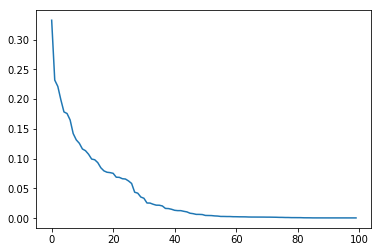

In [653]:
plt.plot(sorted(abs(importances))[::-1][:100])
plt.show()

In [626]:
sorted(abs(importances))[::-1][:10]

[0.6258691,
 0.45977256,
 0.29782683,
 0.2935437,
 0.26517168,
 0.21865349,
 0.16983753,
 0.1108997,
 0.09197595,
 0.00029426836]

In [44]:
sess.run(out, feed_dict={inp : np.array([[1, 1], [-1,-1], [2, -1]])})

array([[-0.57166386,  0.32300174],
       [ 0.57166386, -0.32300174],
       [-1.1433277 , -0.32300174]], dtype=float32)